## Keras  CIFAR-10 MobileNet Estimator Example

MobileNet model exported for both prediction on training on device with tensor/io. Wraps the keras model in an estimator and uses the `experimental_mode` parameter to export for training. Relies on some `compat.v1` apis for optimization and loss functions.

Based on:

- https://www.tensorflow.org/tutorials/images/transfer_learning_with_hub
- https://www.tensorflow.org/tutorials/images/transfer_learning
- https://www.tensorflow.org/guide/migrate#estimators

In [1]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import layers

import PIL.Image as Image
import matplotlib.pylab as plt

%matplotlib inline

In [2]:
def enable_memory_growth():
    physical_devices = tf.config.experimental.list_physical_devices('GPU') 
    try: 
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        # tf.config.gpu.set_per_process_memory_growth(True)
        # tf.config.gpu.set_per_process_memory_fraction(0.75)
    except: 
        print('Invalid device or cannot modify virtual devices once initialized.')

        
if "TF_GPU_GROWTH" in os.environ:
    print("Enabling GPU memory growth")
    enable_memory_growth()

Enabling GPU memory growth


## CIFAR-10

In [3]:
fashion_mnist = tf.keras.datasets.cifar10
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
class_names = [
    'airplane', 
    'automobile', 
    'bird', 
    'cat', 
    'deer', 
    'dog', 
    'frog', 
    'horse', 
    'ship', 
    'truck'
]

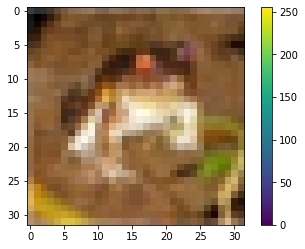

In [5]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

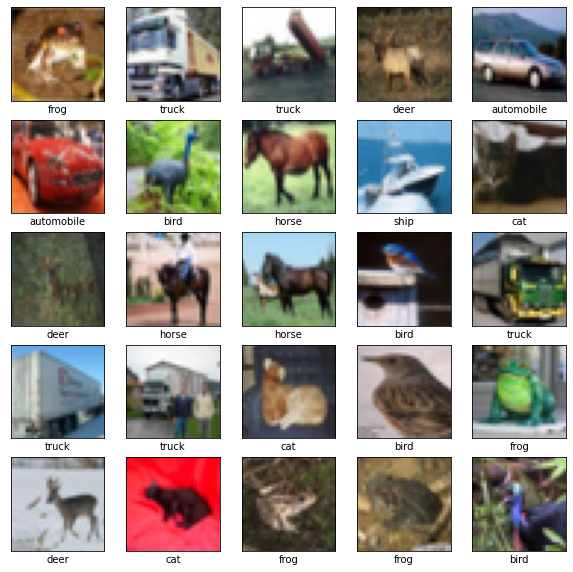

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Resize Images

The smallest MobileNet model takes images that are 96x96 but the CIFAR images are 32x32, so we'll resize them.

In [8]:
train_images.shape

(50000, 32, 32, 3)

In [9]:
train_images_96_x_96 = tf.image.resize(
    train_images, 
    (96,96),
    antialias=True
)

train_images_96_x_96 = train_images_96_x_96.numpy()

test_images_96_x_96 = tf.image.resize(
    test_images, 
    (96,96),
    antialias=True
)

test_images_96_x_96 = test_images_96_x_96.numpy()

In [10]:
train_images_96_x_96.shape

(50000, 96, 96, 3)

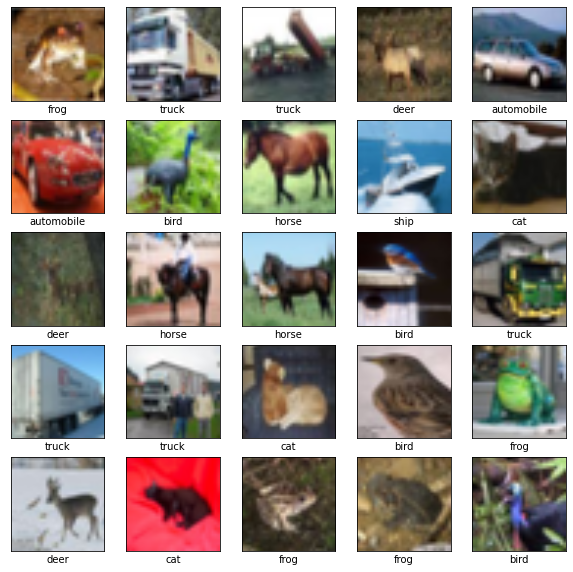

In [11]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images_96_x_96[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

## Estimator

In [12]:
TRAINING_MODEL_DIR='tmp/checkpoints'

In [13]:
TF_HUB_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_96/classification/4"
    # Use version /2 of the model for 1.13 compatibility

def make_model(base_model_trainable=False):
    model = tf.keras.Sequential([
        hub.KerasLayer(TF_HUB_URL, input_shape=(96,96,3), trainable=base_model_trainable),
        tf.keras.layers.Dense(10)
    ])
    return model

In [14]:
# The input function is responsible for feeding data to the estimator

# Note that we are artificially constraining the size of the training set
# so that it fits in 2GB of memory

def input_fn():
    BUFFER_SIZE = 10000
    BATCH_SIZE = 64
    
    train_images_subset = train_images_96_x_96[:10000,:]
    train_labels_subset = train_labels[:10000,:]
    
    dataset = tf.data.Dataset.from_tensor_slices( (train_images_subset, train_labels_subset) )
    
    def scale(image, label):
        # images were scaled prior to displaying them
        # image = tf.cast(image, tf.float32)
        # image /= 255

        return {'image': image}, label # label[..., tf.newaxis]
    
    dataset = dataset.map(scale)
    dataset = dataset.shuffle(BUFFER_SIZE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    
    return dataset

In [15]:
# set base_model_trainable=False for 1.13 compatibility

def model_fn(features, labels, mode):
    training = (mode == tf.estimator.ModeKeys.TRAIN)
    model = make_model(base_model_trainable=True)
    
    predictions = model(features['image'], training=training)

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            predictions=predictions
        )
    
    # 1) 
    # Note this check for labels is None and then acquiring it from the features
    # This is necessary when exporting the model for training
    
    if labels is None:
        labels = features['label']
        # labels = labels[..., tf.newaxis]
    
    optimizer = tf.compat.v1.train.AdamOptimizer()
    
    # SparseCategoricalCrossentropy takes integer labels (indices) while CategoricalCrossentropy 
    # takes one-hot encodings
    
    loss_fn=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    
    reg_losses = model.get_losses_for(None) + model.get_losses_for(features)
    total_loss = loss_fn(labels, predictions) + tf.math.add_n(reg_losses)
    
    # 2)
    # Note we name this total loss op via a tf.identity op, allowing us to access it
    # by name in the session API on device. We'll see this name used in the model.json
    
    total_loss = tf.identity(total_loss, name='total_loss')

    accuracy = tf.compat.v1.metrics.accuracy(
        labels=labels,
        predictions=tf.math.argmax(predictions, axis=1),
        name='acc_op')

    update_ops = model.get_updates_for(None) + model.get_updates_for(features)
    
    minimize_op = optimizer.minimize(
        total_loss,
        var_list=model.trainable_variables,
        global_step=tf.compat.v1.train.get_or_create_global_step())
      
    # 3)
    # Note that we explicitly name this grouping operation, effectively giving us a way
    # to execute the minimize op above via the session api. Often we can just name the
    # minimize op directly
    
    train_op = tf.group(minimize_op, update_ops, name='train')

    return tf.estimator.EstimatorSpec(
        mode=mode,
        predictions=predictions,
        loss=total_loss,
        train_op=train_op, 
        eval_metric_ops={'accuracy': accuracy}
    )

In [16]:
STEPS_PER_EPOCH = 5
NUM_EPOCHS = 10

train_spec = tf.estimator.TrainSpec(
    input_fn=input_fn,
    max_steps=STEPS_PER_EPOCH * NUM_EPOCHS
    )

eval_spec = tf.estimator.EvalSpec(
    input_fn=input_fn,
    steps=STEPS_PER_EPOCH
    )

In [17]:
! rm -r 'tmp/checkpoints'

In [18]:
estimator = tf.estimator.Estimator(model_fn=model_fn, model_dir=TRAINING_MODEL_DIR)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe511f44358>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Not using Distribute Coordinator.
INFO:te

INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:Saving checkpoints for 0 into tmp/checkpoints/model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into tmp/checkpoints/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:loss = 3.3672175, step = 0


INFO:tensorflow:loss = 3.3672175, step = 0


INFO:tensorflow:Saving checkpoints for 50 into tmp/checkpoints/model.ckpt.


INFO:tensorflow:Saving checkpoints for 50 into tmp/checkpoints/model.ckpt.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-05-29T11:08:01Z


INFO:tensorflow:Starting evaluation at 2020-05-29T11:08:01Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/5]


INFO:tensorflow:Evaluation [1/5]


INFO:tensorflow:Evaluation [2/5]


INFO:tensorflow:Evaluation [2/5]


INFO:tensorflow:Evaluation [3/5]


INFO:tensorflow:Evaluation [3/5]


INFO:tensorflow:Evaluation [4/5]


INFO:tensorflow:Evaluation [4/5]


INFO:tensorflow:Evaluation [5/5]


INFO:tensorflow:Evaluation [5/5]


INFO:tensorflow:Finished evaluation at 2020-05-29-11:08:14


INFO:tensorflow:Finished evaluation at 2020-05-29-11:08:14


INFO:tensorflow:Saving dict for global step 50: accuracy = 0.371875, global_step = 50, loss = 7.1496253


INFO:tensorflow:Saving dict for global step 50: accuracy = 0.371875, global_step = 50, loss = 7.1496253


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50: tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 50: tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Loss for final step: 1.1572728.


INFO:tensorflow:Loss for final step: 1.1572728.


({'accuracy': 0.371875, 'loss': 7.1496253, 'global_step': 50}, [])

## Export Model for Prediction

We'll use the `save_model` function below to export for both training and prediction

In [19]:
# Read below for why we must disable this option before saving the model

tf.config.optimizer.set_experimental_options({
    'remapping': False
})

In [20]:
def save_model(model_dir, output_dir, serving_input_receiver_fn, mode=tf.estimator.ModeKeys.PREDICT):
    
    estimator = tf.estimator.Estimator(
        model_fn=model_fn,
        model_dir=model_dir
    )
    
    estimator.export_saved_model(
        output_dir,
        lambda:serving_input_receiver_fn(),
        as_text=False,
        experimental_mode=mode
    )

In [21]:
# The serving input receiver function establishes the signature definitions
# for our exported model

def serving_input_predict_receiver_fn():
    image_shape = [None, 96, 96, 3]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [22]:
EXPORT_MODEL_DIR='tmp/keras-cifar10-mobilenet-estimator-predict'

save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_predict_receiver_fn)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe511fd1240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe511fd1240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Train: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:SavedModel written to: tmp/keras-cifar10-mobilenet-estimator-predict/temp-b'1590775717'/saved_model.pb


INFO:tensorflow:SavedModel written to: tmp/keras-cifar10-mobilenet-estimator-predict/temp-b'1590775717'/saved_model.pb


### Results

In [24]:
# Set the trailing model id to the value produced by the exporter

! saved_model_cli show --all --dir tmp/keras-cifar10-mobilenet-estimator-predict/1590775717


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 3)
        name: image:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense/BiasAdd:0
  Method name is: tensorflow/serving/predict


### Tensor/IO

Note in the corresponding model.json that the name and shape of the inputs and outputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 96, 96, 3)
    name: image:0

outputs['output'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 10)
    name: sequential/dense/BiasAdd:0
```

In [25]:
! cat model.predict.json

{
	"name": "Keras CIFAR-10 MobileNet Estimator Example",
	"details": "Keras MobileNetV2 Model for CIFAR-10 dataset exported for prediction using the estimator api",
	"id": "keras-mnist-fashion-estimator-predict",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "predict",
		"quantized": false,
		"type": "cifar10.estimator",
		"backend": "tensorflow",
		"modes": ["predict"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "image",
			"shape": [-1,96,96,3],
			"format": "RGB",
			"normalize": {
				"standard": "[0,1]"
			}
		}
	],
	"outputs": [
		{
			"name": "sequential/dense/BiasAdd",
			"type": "array",
			"shape": [-1,10]
		}
	]
}

The initial execution of this model fails on device because of a missing kernel: `FusedBatchNorm`. This kernel is contained in *fused_batch_norm_op.cc*, which has been whitelisted, but it is still not compiling into the on device build.

FusedBatchNorm is an optimized operation that combines other ops and is controlled by the remapper option in grappler when exporting the model, see: https://www.tensorflow.org/guide/graph_optimization, remapper optimizer.

Disable the remapper optimization in grappler with the following code before saving the model:

```
tf.config.optimizer.set_experimental_options({
    'remapping': False
})
```

Once the remapper optimization has been disabled, I am able to run the model on device as expected.

## Export Model for Training

In [26]:
# The serving input receiver function establishes the signature definitions
# for our exported model

# We also include the label here, which allows us to pass the label as an 
# input to the model. This is how we are able to get the label from the 
# features param in the model_fn when labels is None (see [1] in model_fn)

def serving_input_train_receiver_fn():
    image_shape = [None, 96, 96, 3]
    label_shape = [None, 1]
    
    inputs = {
        'image': tf.compat.v1.placeholder(tf.float32, shape=image_shape, name='image'),
        'label': tf.compat.v1.placeholder(tf.int32, shape=label_shape, name='label')
    }
    
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

In [27]:
EXPORT_MODEL_DIR='tmp/keras-cifar10-mobilenet-estimator-train'

save_model(TRAINING_MODEL_DIR, EXPORT_MODEL_DIR, serving_input_train_receiver_fn, mode=tf.estimator.ModeKeys.TRAIN)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe18d33ca20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'tmp/checkpoints', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe18d33ca20>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Classify: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Regress: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Predict: None


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Train: ['train']


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Signatures INCLUDED in export for Eval: None


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Restoring parameters from tmp/checkpoints/model.ckpt-50


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:Assets added to graph.


INFO:tensorflow:No assets to write.


INFO:tensorflow:No assets to write.


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'list' object has no attribute 'name'


INFO:tensorflow:SavedModel written to: tmp/keras-cifar10-mobilenet-estimator-train/temp-b'1590775741'/saved_model.pb


INFO:tensorflow:SavedModel written to: tmp/keras-cifar10-mobilenet-estimator-train/temp-b'1590775741'/saved_model.pb


### Results

In [28]:
# Set the trailing model id to the value produced by the exporter

! saved_model_cli show --all --dir tmp/keras-cifar10-mobilenet-estimator-train/1590775741


MetaGraphDef with tag-set: 'train' contains the following SignatureDefs:

signature_def['train']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['image'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 96, 96, 3)
        name: image:0
    inputs['label'] tensor_info:
        dtype: DT_INT32
        shape: (-1, 1)
        name: label:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['loss'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: total_loss:0
    outputs['metrics/accuracy/update_op'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/update_op:0
    outputs['metrics/accuracy/value'] tensor_info:
        dtype: DT_FLOAT
        shape: ()
        name: acc_op/value:0
    outputs['predictions'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: sequential/dense/BiasAdd:0
  Method name is: tensorflow/supervised/training


### Tensor/IO

Note in the corresponding model.json that the name, shape, and **data type** of the inputs matches the values you see in the signature definition. Take special care to note that the name is taken from the layer's name and not from the key in the inputs or outputs dictionary:

```
inputs['image'] tensor_info:
    dtype: DT_FLOAT
    shape: (-1, 96, 96, 3)
    name: image:0
inputs['label'] tensor_info:
    dtype: DT_INT32
    shape: (-1, 1)
    name: label:0
```

Also note that, for training, we'll take the loss value as the preferred output and ignore the other outputs, using the name we explicitly assigned in [2]:

```
outputs['loss'] tensor_info:
    dtype: DT_FLOAT
    shape: ()
    name: total_loss:0
```

Finally, although we don't see it in the saved model output, we must also include the op we will call in the model.json file to actually execute training. See [3] in model_fn where we name the `tf.group` op which includes the minimization op.

In [29]:
! cat model.train.json

{
	"name": "Keras MNIST Fashion Estimator Train Example",
	"details": "Basic Keras Model for Fashion MNSIT dataset exported using the estimator apis and an experimental mode for training",
	"id": "keras-mnist-fashion-estimator-train",
	"version": "1",
	"author": "doc.ai",
	"license": "Apache License. Version 2.0 http://www.apache.org/licenses/LICENSE-2.0",
	"model": {
		"file": "train",
		"quantized": false,
		"type": "cifar10.estimator",
		"backend": "tensorflow",
		"modes": ["train"]
	},
	"inputs": [
		{
			"name": "image",
			"type": "image",
			"shape": [-1,96,96,3],
			"format": "RGB",
			"normalize": {
				"standard": "[0,1]"
			}
		},
		{
			"name": "label",
			"type": "array",
			"dtype": "int32",
			"shape": [-1,1]
		}
	],
	"outputs": [
		{
			"name": "total_loss",
			"type": "array",
			"shape": [1]
		}
	],
	"train": {
		"ops": [
			"train"
		]
	}
}

We can execute training on device after whitelisting a kernel for the `SparseSoftmaxCrossEntropyWithLogits` op (*core/kernels/sparse_xent_op.cc*). The model trains correctly.